# COGS 108 - Final Project 

# Name & PID

- Name: Samuel Hayes
- PID: A15613044

# Overview

In order to establish the features that are associated with failed inspections, I extracted the failed inspections from the database and determined if certain categorical variables were overrepresented in this dataset as compared to the full dataset. I found that while restaurants were the most common type of facility being inspected, they were still disproportionately overrepresented in the failed inspections dataset. In conducting the same test for the overrepresentation of inspector id in the failed inspections dataset, I discovered that several of the inspectors were disproportionately overrepresented in the failed inspections dataset as well. This discovery suggests that while the number of overall inspections was distributed fairly well across many inspectors, the inspections that resulted in failures were most often conducted by 6 or 7 (presumably harsh) inspectors. I concluded my analysis by conducting several regression models which test the amount of variability in the scores that certain predictors (features) can account for. 

## Background and Prior Work

In my search for information about the health inspection process in North Carolina, I came across a thorough website created by the Wake County Food Safety and Sanitation Department. Wake County is one of the two most populous counties in North Carolina, so I believe that their system and protocol is representative of that of the state at large. The website provided a link to search for the current inspection scores of particular restaurants. From other pages I discovered that the restaurant inspection protocol is much the same in NC as it is in California, where I had originally researched for my Project Proposal. While I did not have the time to research the NC food code in its entirety, I found it sufficient to review the risk-based inspection rules, which specified the criteria of a critical violation and the need for it to be met within 10 days (if not while the inspector is on-site). I also found a pdf of the food inspection form, which may be useful for reference in understanding the points-based scoring process.

References (include links):
- 1)https://ehs.ncpublichealth.com/docs/forms/FoodInspectionForm-Mar13.pdf
- 2)http://www.wakegov.com/food/healthinspections/tidbits/Pages/newrules.aspx

# Research Question

What features are most often associated with a failed inspection (by my definition, score < 90)? I will search for relationships with previous inspection data, particular inspectors, and the type of facility.

# Hypothesis


I hypothesize that the most accurate predictors of a failed inspection will be the previous inspection scores and the time since the previous inspection. I believe that most often businesses do not fully change their practices after receiving violations from the Health Department, but will slip back into the same habits over time.

# Dataset(s)


- Dataset Name: Inspections
- Link to the dataset: https://github.com/COGS108/Projects/tree/master/Option2_Individual/data/inspections.csv
- Number of observations: This dataset includes 18466 inspection data points, which each consist of up to 36 inspection features.

The inspections dataset contains a thorough account of restaurant inspections in North Carolina from August 2012 to November 2016. It is organized by date of inspection. Approximately 3000 inspection events have no previous inspection data, according to the consistency across features that refer to previous inspections. I believe this dataset is rich enough and expansive enough in scope to conduct a far-reaching data analysis without combining it with other datasets.

# Setup

In [1]:
import pandas as pd
import numpy as np

# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(style="white", font_scale=2)

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7)

# Statmodels & patsy
import patsy
import statsmodels.api as sm
from scipy.stats import pearsonr, norm, ttest_ind

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

#improve resolution
%config InlineBackend.figure_format ='retina'

In [2]:
inspections = pd.read_csv('data/inspections.csv')

In [3]:
inspections.shape

(18466, 36)

In [4]:
list(inspections)

['hsisid',
 'date',
 'name',
 'address1',
 'address2',
 'city',
 'state',
 'postalcode',
 'phonenumber',
 'restaurantopendate',
 'days_from_open_date',
 'facilitytype',
 'x',
 'y',
 'geocodestatus',
 'zip',
 'type',
 'description',
 'inspectedby',
 'inspection_num',
 'inspector_id',
 'previous_inspection_date',
 'days_since_previous_inspection',
 'previous_inspection_by_same_inspector',
 'score',
 'num_critical',
 'num_non_critical',
 'num_critical_previous',
 'num_non_critical_previous',
 'num_critical_mean_previous',
 'num_non_critical_mean_previous',
 'avg_neighbor_num_critical',
 'avg_neighbor_num_non_critical',
 'top_match',
 'second_match',
 'critical']

In [5]:
inspections.isna().any()

hsisid                                   False
date                                     False
name                                     False
address1                                 False
address2                                  True
city                                     False
state                                    False
postalcode                               False
phonenumber                               True
restaurantopendate                       False
days_from_open_date                      False
facilitytype                             False
x                                        False
y                                        False
geocodestatus                            False
zip                                      False
type                                     False
description                               True
inspectedby                               True
inspection_num                           False
inspector_id                              True
previous_insp

In [6]:
#checking the first date an inspection was conducted
inspections['date'][0]

'2012-09-21T00:00:00Z'

In [7]:
#understanding the range of dates that the data were collected
inspections['date'][18465]

'2016-11-03T00:00:00Z'

In [8]:
#which states' inspections are being collected in the dataset
inspections['state'].value_counts()

NC    18466
Name: state, dtype: int64

In [9]:
inspections['hsisid'].value_counts()

4092110059    16
4092090012    16
4092015613    16
4092110101    15
4092110083    15
4092110124    15
4092110071    15
4092110473    15
4092110041    15
4092110088    15
4092110066    15
4092110130    15
4092110103    15
4092110076    14
4092012198    14
4092110465    14
4092110105    14
4092110001    14
4092110481    14
4092110006    14
4092110092    14
4092110464    14
4092110131    14
4092110031    14
4092110133    13
4092021380    13
4092110151    13
4092110068    13
4092110077    13
4092110154    13
              ..
4092017156     1
4092017190     1
4092300271     1
4092017188     1
4092017158     1
4092017300     1
4092017316     1
4092030294     1
4092300274     1
4092017094     1
4092017078     1
4092140596     1
4092021946     1
4092021922     1
4092021847     1
4092140584     1
4092017340     1
4092017292     1
4092017228     1
4092017212     1
4092017196     1
4092017180     1
4092017164     1
4092017148     1
4092017132     1
4092021943     1
4092017100     1
4092017084    

In [10]:
inspections['inspection_num'].value_counts()

1     3045
2     2828
3     2610
4     2424
5     2200
6     1838
7     1407
8      946
9      559
10     298
11     156
12      78
13      37
14      24
15      13
16       3
Name: inspection_num, dtype: int64

# Data Cleaning

First I will remove features (columns) whose meaning I cannot make complete sense of without knowing the criteria, such as the average neighbor and matches (top_match and second_match). Next, I will remove redundancies, making sure to keep the information which is contained in a more useful form for my analysis. I noticed that zip contains the same information as postalcode, but is stored in the form of an integer; I believe it is more useful to think of the zipcode as a string, so I keep the postalcode column (I provide this example to demonstrate the type of thinking that I use to make these decisions). Similarly, I will use the number of days since previous inspection, which is a more useful encoding of the previous inspection date. I will remove the names of the inspectors to maintain anonymity as I assess the distribution of their scoring. I will treat hsisid as the only suitable feature to determine the uniqueness of a business because the value counts of this column match the value counts of the inspection number (a facility's id should show up as many times as the number of inspections). Because of this, for my purposes the name, restaurant open date, and phone number are useless as I conduct my analysis; I will remove them to avoid clutter in the dataset. I will remove the state column because we are certain that all inspections come from North Carolina. I will remove all geographical information, as I am not assessing the influence of location in my analysis.

In [11]:
inspections = inspections.drop(['avg_neighbor_num_critical', 'avg_neighbor_num_non_critical', 'top_match', 'second_match'], axis = 1)

In [12]:
inspections = inspections.drop(['geocodestatus', 'postalcode','x', 'y', 'city', 'zip', 'type', 'inspectedby', 'address1', 'address2' , 'state', 'name', 'phonenumber', 'previous_inspection_date', 'days_from_open_date', 'description', 'postalcode'], axis = 1)
inspections.head()

,hsisid,date,restaurantopendate,facilitytype,inspection_num,inspector_id,days_since_previous_inspection,previous_inspection_by_same_inspector,score,num_critical,num_non_critical,num_critical_previous,num_non_critical_previous,num_critical_mean_previous,num_non_critical_mean_previous,critical
0,4092013748,2012-09-21T00:00:00Z,2002-12-21T00:00:00Z,Restaurant,1,27.0,NaN,NaN,96.0,9,7,NaN,NaN,NaN,NaN,1
1,4092014046,2012-09-21T00:00:00Z,2004-05-04T00:00:00Z,Restaurant,1,7.0,NaN,NaN,98.0,0,11,NaN,NaN,NaN,NaN,0
2,4092015191,2012-09-21T00:00:00Z,2008-08-04T00:00:00Z,Restaurant,1,3.0,NaN,NaN,97.0,4,8,NaN,NaN,NaN,NaN,1
3,4092016122,2012-09-21T00:00:00Z,2012-03-28T00:00:00Z,Restaurant,1,24.0,NaN,NaN,99.0,2,3,NaN,NaN,NaN,NaN,1
4,4092021513,2012-09-21T00:00:00Z,2008-02-25T00:00:00Z,Food Stand,1,7.0,NaN,NaN,97.0,2,4,NaN,NaN,NaN,NaN,1


In [13]:
inspections = inspections.astype({'inspector_id' : str})

# Data Analysis & Results

First I will extract the data points where the inspection was failed. By checking the value counts of id's in this group, I can establish how often facilities failed multiple times.

In [14]:
fi = inspections[inspections['score'] < 90]
fi_id = inspections['hsisid'][inspections['score'] < 90]
fi_num = inspections['inspection_num'][inspections['score'] < 90]
fi_scores = inspections['score'][inspections['score'] < 90]

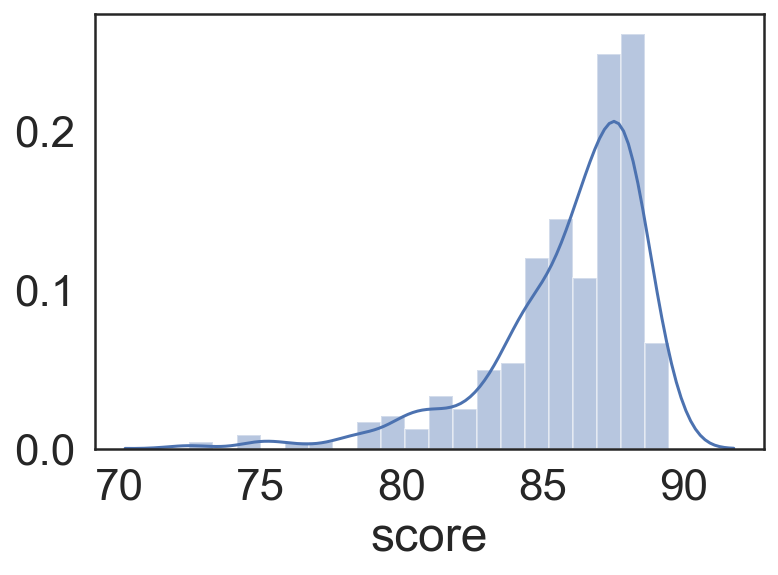

In [15]:
sns.distplot(fi_scores, bins = 20)

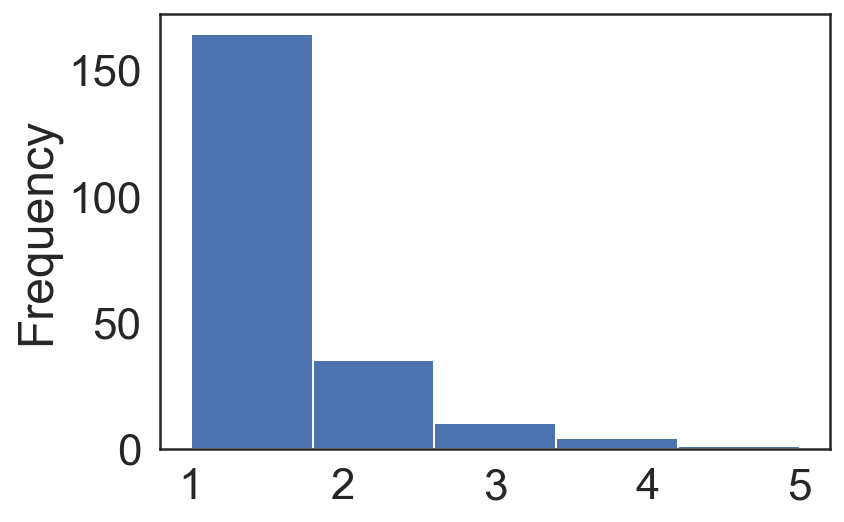

In [16]:
fi_id.value_counts().plot('hist', bins = 5)

From this barplot, it appears that it is much more common for a facility to fail once, but there are more than 50 facilities that fail multiple times.

In [17]:
fi['facilitytype'].value_counts('Restaurant')

Restaurant                    0.891228
Food Stand                    0.066667
Mobile Food Units             0.021053
Meat Market                   0.010526
Institutional Food Service    0.007018
Pushcarts                     0.003509
Name: facilitytype, dtype: float64

In [18]:
len(fi[fi['facilitytype'] == 'Restaurant'])/ len(fi)

0.8912280701754386

In [19]:
inspections['facilitytype'].value_counts('Restaurant')

Restaurant                           0.649031
Food Stand                           0.176162
Public School Lunchrooms             0.085942
Meat Market                          0.039803
Institutional Food Service           0.019441
Mobile Food Units                    0.011535
Private School Lunchrooms            0.007311
Pushcarts                            0.006878
Elderly Nutrition Sites (catered)    0.003737
Limited Food Service                 0.000162
Name: facilitytype, dtype: float64

Restaurants fail inspections disproportionately more often than other types of facilities.

In [20]:
inspections['inspector_id'].value_counts(1.0)

1.0     0.074136
10.0    0.070508
25.0    0.068613
28.0    0.063576
7.0     0.061248
2.0     0.058053
22.0    0.057511
18.0    0.054533
3.0     0.051825
6.0     0.050200
5.0     0.048955
15.0    0.046680
9.0     0.044352
23.0    0.033250
21.0    0.031192
11.0    0.030705
8.0     0.020957
16.0    0.018737
29.0    0.018304
27.0    0.017979
14.0    0.017004
31.0    0.014621
32.0    0.011426
20.0    0.009260
24.0    0.008827
4.0     0.007527
13.0    0.005036
19.0    0.004224
nan     0.000271
12.0    0.000217
26.0    0.000217
17.0    0.000054
Name: inspector_id, dtype: float64

In [21]:
fi['inspector_id'].value_counts(2.0)

2.0     0.185965
25.0    0.154386
1.0     0.119298
31.0    0.101754
22.0    0.084211
28.0    0.063158
27.0    0.052632
18.0    0.042105
15.0    0.038596
8.0     0.024561
7.0     0.021053
11.0    0.021053
23.0    0.017544
5.0     0.014035
14.0    0.010526
6.0     0.010526
21.0    0.007018
9.0     0.007018
13.0    0.007018
4.0     0.007018
10.0    0.003509
32.0    0.003509
20.0    0.003509
Name: inspector_id, dtype: float64

In [22]:
outcome, predictors = patsy.dmatrices('score ~ num_critical + num_non_critical', inspections)
mod = sm.OLS(outcome, predictors)  
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                 1.140e+04
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:21:18   Log-Likelihood:                -36802.
No. Observations:               18466   AIC:                         7.361e+04
Df Residuals:                   18463   BIC:                         7.363e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           98.9235      0.023  

This linear regression model accounts for over 50% of the variability in scores. If every critical violation and non-critical violation was weighted the same, you would expect nearly 100% of the variability in scores to be determined by the number of critical and non-critical violations. This demonstrates that there is some variation in the meaning of a violation, possibly through some specific criteria or the discretion of the inspector.

In [23]:
outcome, predictors = patsy.dmatrices('score ~ inspector_id + facilitytype', inspections)
mod = sm.OLS(outcome, predictors)  
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     150.1
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:21:18   Log-Likelihood:                -41668.
No. Observations:               18461   AIC:                         8.342e+04
Df Residuals:                   18421   BIC:                         8.373e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

As I suggested above, the inspector id and facility type have a certain (albeit limited) range of predictive power in determining the score of an inspection. 

In [24]:
outcome, predictors = patsy.dmatrices('score ~ num_critical_mean_previous + num_non_critical_mean_previous', inspections)
mod = sm.OLS(outcome, predictors)  
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     3148.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:21:18   Log-Likelihood:                -34445.
No. Observations:               15421   AIC:                         6.890e+04
Df Residuals:                   15418   BIC:                         6.892e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

After running a few variations of the multiple regression above, it appears that the mean number of critical and non-critical previous violations has the best statistical power to predict the score of a given inspection (provided that we don't already have the violation data for that inspection). This finding demonstrates that while a facility's previous inspection can be important in determining the outcome of the current, the aggregration of all their previous inspections reveals more about their likely score.

In [25]:
outcome, predictors = patsy.dmatrices('score ~ num_critical_mean_previous + num_non_critical_mean_previous', inspections[inspections['score'] < 90])
mod = sm.OLS(outcome, predictors)  
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     4.560
Date:                Tue, 09 Jun 2020   Prob (F-statistic):             0.0113
Time:                        19:21:18   Log-Likelihood:                -623.91
No. Observations:                 259   AIC:                             1254.
Df Residuals:                     256   BIC:                             1264.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Strangely, by running the same model on the failed inspections, we discover that the same features are a very poor predictor of score. This phenomenon suggests that business who fail their inspections are not bound very tightly in  relationship with previous scores. There is a possibility that most failed inspections are out of the normal character of the facility that received the score. This suggestion is supported by the fact that most facilities who fail only fail once, while most facilities were tested from 4-9 times within the period.

# Ethics & Privacy

Much of the content of the database that I have been given to conduct an analysis of is public information by design. Information about each restaurant's current inspection score is available both physically (usually in the shop window) and online in the Food Safety Department's database. The primary detail that should not be made available is the indentity of the inspector. Many other features point to the location of the business, which should be available to any interested citizen. Overall, the inspection system is designed by government agencies to maintain that food facilities are following health protocols and that citizens are aware of any withstanding violations. Because of this, privacy concerns do not apply, except in the case already specified. 

# Conclusion & Discussion

Throughout the course of this project, I formed many ideas as to how I could run a poignant analysis that suitably answers my research question. I was able to manifest almost none of these methods in code, making my project a marked failure from my perspective. I first wished to determine how well a facility does in their next inspection after they've received a failing score. I had hoped to determine if giving a facility a failing score is an effective motivation for bettering their practices in the future. After several hours attempting to implement code that would be able to find the next instance of a given hsisid (the inspection conducted directly after the facility's fail), I was unsuccessful.

Next I arrived at a new research question, which still dealt with failed inspections (or those with a score below 90). I chose this population of inspections because I noticed that the vast majority of inspections receive a score above 90, making it difficult to localize the features responsible for this result. By extracting the instances of an unsuccessful inspection, I felt that I could learn more about the features that effect the results of inspections overall. 

After I ran the value counts assessment of facility type and inspector-id, I hoped to display these in a barplot which would, for each variable, compare the proportion of instances in the inspections dataset as a whole against the proportion of instances in the failed inspections dataset. I believed this would memorably represent the differences across categories. This, too, I failed to create, as I could not navigate the seaborn documentation to arrive at the syntax necessary. I feel that with a visualization this finding would have been one of the more interesting discoveries of my analysis, but my failure to express this phenomenon visually detracts heavily from the audience's ability to comprehend it fully. 

As approached a linear model, I hoped to develop a model that would predict a facility's score based on features that didn't include the violations recorded in their inspection. With regards to using the previous violations data (critical and non-critical) to predict the score of the current inspection, I had originally hoped to create a system that would find the previous score of a facility using its id and use that feature to predict the current score. Although I was unable to manage this, I found that the previous violations data did have a certain level of predictive power; however, when I attempted to use a similar relationship (mean previous instead of previous) to predict the scores of a failed inspections, I found that the relationship did not hold. This detail leads me to believe that a facility's inspection history cannot effectively predict when it will fail an inspection. I conclude that most failed inspections are essentially flukes, which are likely influenced by the identity of the inspector. In the future, I hope to analyze how a facility responds after they've failed an inspection. The relatively low number of repeated failures suggests that most facilities set themselves straight after one failed inspection, but I hope to conduct a more thorough analysis and possibly erect categories over certain facilities where they already exist